# Import Modules

In [14]:
import sys
import os
import pandas as pd
import tqdm as tqdm
import xgboost as xgb
import numpy as np

# Import your custom modules. Adjust the module paths as needed.
from src.data.load_data import loadTrainingData
from sklearn.model_selection import train_test_split
from src.features.create_feature_vectors import extract_features_with_expanding_window
from src.plots.feature_plots import plot_roc_auc, plot_confusion_matrix
from sklearn.metrics import classification_report,fbeta_score,confusion_matrix
from sklearn import set_config

set_config(display="text")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', None)


# Load Data

In [15]:
directories = ['../../training_setA/', '../../training_setB/']
max_files = 10000  # Adjust as needed

patient_dict = {}

for directory in directories:
    pattern = os.path.join(directory, "*.psv")
    print(f"\nLoading data from: {pattern} with max_files={max_files}")
    patient_data = loadTrainingData(
        pattern,
        max_files,
        ignore_columns=[]
    )
    patient_dict.update(patient_data)


Loading data from: ../../training_setA/*.psv with max_files=10000


Loading PSV Files: 100%|██████████| 10000/10000 [00:10<00:00, 966.80it/s]



Loading data from: ../../training_setB/*.psv with max_files=10000


Loading PSV Files: 100%|██████████| 10000/10000 [00:10<00:00, 941.97it/s]


# Create Feature Vectors

In [ ]:
feature_df = extract_features_with_expanding_window(patient_dict)

 # Save or Load Feature

In [ ]:
def save_feature_data(feature_df, file_path="feature_data.pkl"):
    feature_df.to_pickle(file_path)
    print(f"Feature data saved to {file_path}")

def load_feature_data(file_path="feature_data.pkl"):
    feature_df = pd.read_pickle(file_path)
    print(f"Feature data loaded from {file_path}")
    return feature_df

# feature_df = load_feature_data()
save_feature_data(feature_df)

Feature data loaded from feature_data.pkl


# Add/Remove features

In [18]:
feature_df.columns

Index(['HR_5_mean', 'HR_5_min', 'HR_5_max', 'HR_5_median', 'HR_5_var',
       'HR_5_q95', 'HR_5_q05', 'HR_5_energy', 'HR_5_slope', 'O2Sat_5_mean',
       'O2Sat_5_min', 'O2Sat_5_max', 'O2Sat_5_median', 'O2Sat_5_var',
       'O2Sat_5_q95', 'O2Sat_5_q05', 'O2Sat_5_energy', 'O2Sat_5_slope',
       'Temp_5_mean', 'Temp_5_min', 'Temp_5_max', 'Temp_5_median',
       'Temp_5_var', 'Temp_5_q95', 'Temp_5_q05', 'Temp_5_energy',
       'Temp_5_slope', 'SBP_5_mean', 'SBP_5_min', 'SBP_5_max', 'SBP_5_median',
       'SBP_5_var', 'SBP_5_q95', 'SBP_5_q05', 'SBP_5_energy', 'SBP_5_slope',
       'MAP_5_mean', 'MAP_5_min', 'MAP_5_max', 'MAP_5_median', 'MAP_5_var',
       'MAP_5_q95', 'MAP_5_q05', 'MAP_5_energy', 'MAP_5_slope', 'DBP_5_mean',
       'DBP_5_min', 'DBP_5_max', 'DBP_5_median', 'DBP_5_var', 'DBP_5_q95',
       'DBP_5_q05', 'DBP_5_energy', 'DBP_5_slope', 'Resp_5_mean', 'Resp_5_min',
       'Resp_5_max', 'Resp_5_median', 'Resp_5_var', 'Resp_5_q95', 'Resp_5_q05',
       'Resp_5_energy', 'Resp_5_s

In [19]:
feature_df.shape

(769652, 105)

# Split Sets into Test and Train on Patient ID of Dictionary

In [20]:
# Group rows by patient_id to create a patient-wise dictionary.
patient_groups = {patient_id: group 
                  for patient_id, group in feature_df.groupby("patient_id")}

# Create a new dictionary with keys indicating sepsis status.
# For each patient, if any row's SepsisLabel equals 1, mark that patient as sepsis.
labeled_patients = {}
for patient_id, df in patient_groups.items():
    # Check if the patient ever had sepsis
    sepsis_label = "1" if df["SepsisLabel"].any() else "0"
    new_key = f"{patient_id}_{sepsis_label}"
    labeled_patients[new_key] = df

# Optional: Print counts to verify split counts
sepsis_count = sum(1 for key in labeled_patients if key.endswith('_1'))
nonsepsis_count = sum(1 for key in labeled_patients if key.endswith('_0'))
print(f"Number of SEPSIS patients: {sepsis_count}")
print(f"Number of NON-SEPSIS patients: {nonsepsis_count}")

# Now, create a list of keys and a matching list of binary labels for stratification.
keys = list(labeled_patients.keys())
labels = [1 if key.endswith('_sepsis') else 0 for key in keys]  # 1 = sepsis, 0 = no sepsis

# Split the keys into train and test sets while maintaining the sepsis proportion.
train_keys, test_keys, _, _ = train_test_split(
    keys, labels, test_size=0.2, random_state=42, stratify=labels
)

# Build train and test dictionaries from the split keys.
train_data_dict = {key: labeled_patients[key] for key in train_keys}
test_data_dict = {key: labeled_patients[key] for key in test_keys}

# Optional: Verify the stratification in your splits.
train_sepsis = sum(1 for key in train_data_dict if key.endswith('_1'))
test_sepsis = sum(1 for key in test_data_dict if key.endswith('_1'))
print(f"Train SEPSIS: {train_sepsis}, NON-SEPSIS: {len(train_data_dict) - train_sepsis}")
print(f"Test SEPSIS: {test_sepsis}, NON-SEPSIS: {len(test_data_dict) - test_sepsis}")

# If needed, you can also concatenate these dictionaries back into DataFrames:
train_df = pd.concat(train_data_dict.values(), ignore_index=True)
test_df = pd.concat(test_data_dict.values(), ignore_index=True)

train_df = train_df.drop(columns=['patient_id'])
test_df = test_df.drop(columns=['patient_id'])

Number of SEPSIS patients: 1440
Number of NON-SEPSIS patients: 18560
Train SEPSIS: 1165, NON-SEPSIS: 14835
Test SEPSIS: 275, NON-SEPSIS: 3725


#  Train Model

In [21]:
# Separate features and target
X_train = train_df.drop(columns=["SepsisLabel"], errors="ignore")
y_train = train_df["SepsisLabel"]

X_test = test_df.drop(columns=["SepsisLabel"], errors="ignore")
y_test = test_df["SepsisLabel"]

neg_samples, pos_samples = y_train.value_counts()
neg_samples_test, pos_samples_test = y_test.value_counts()
print(f"Negative samples of Train: {neg_samples}, Positive samples of Train: {pos_samples}")
print(f"Negative samples of Test: {neg_samples_test}, Positive samples of Test: {pos_samples_test}")

Negative samples of Train: 605181, Positive samples of Train: 11067
Negative samples of Test: 150769, Positive samples of Test: 2635


In [22]:
# Cell 5: Train model
model = xgb.XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    eval_metric="auc",
    scale_pos_weight=neg_samples / pos_samples
)
model.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)],
          verbose=1)

[0]	validation_0-auc:0.77305
[1]	validation_0-auc:0.78629
[2]	validation_0-auc:0.78774
[3]	validation_0-auc:0.79181
[4]	validation_0-auc:0.79751
[5]	validation_0-auc:0.80084
[6]	validation_0-auc:0.80032
[7]	validation_0-auc:0.80076
[8]	validation_0-auc:0.80187
[9]	validation_0-auc:0.80125
[10]	validation_0-auc:0.80079
[11]	validation_0-auc:0.80009
[12]	validation_0-auc:0.80019
[13]	validation_0-auc:0.80264
[14]	validation_0-auc:0.80354
[15]	validation_0-auc:0.80187
[16]	validation_0-auc:0.80240
[17]	validation_0-auc:0.80069
[18]	validation_0-auc:0.80017
[19]	validation_0-auc:0.79815
[20]	validation_0-auc:0.79699
[21]	validation_0-auc:0.79599
[22]	validation_0-auc:0.79584
[23]	validation_0-auc:0.79485
[24]	validation_0-auc:0.79363
[25]	validation_0-auc:0.79253
[26]	validation_0-auc:0.79228
[27]	validation_0-auc:0.79181
[28]	validation_0-auc:0.79101
[29]	validation_0-auc:0.78962
[30]	validation_0-auc:0.78988
[31]	validation_0-auc:0.79077
[32]	validation_0-auc:0.79077
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

# Evaluate Model

Subset ROC AUC (predicted=1 or actual=1): 0.227


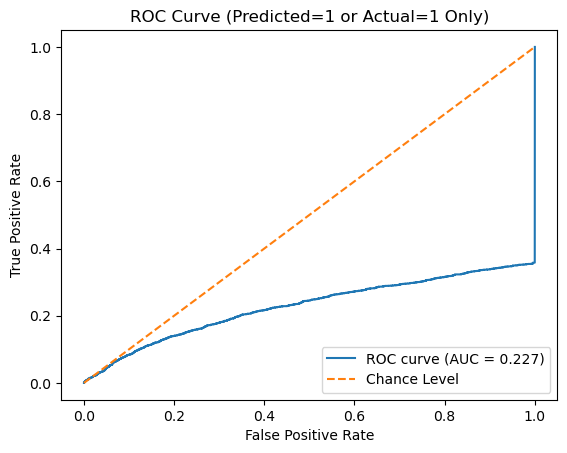

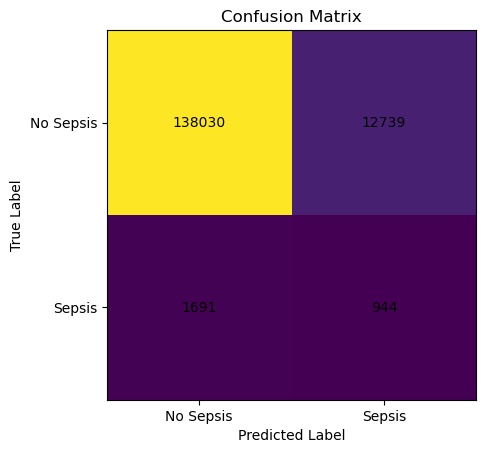


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95    150769
         1.0       0.07      0.36      0.12      2635

    accuracy                           0.91    153404
   macro avg       0.53      0.64      0.53    153404
weighted avg       0.97      0.91      0.94    153404



In [23]:
from src.plots.feature_plots import plot_roc_auc, plot_confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

plot_roc_auc(model, X_test, y_test)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, labels=("No Sepsis", "Sepsis"))

# Print classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Maximise Threshold

In [24]:
thresholds = np.arange(0.0, 1.0, 0.01)

f_beta_scores = []
beta_val = 5.5

for t in thresholds:
    y_pred_threshold = (y_proba >= t).astype(int)
    fb = fbeta_score(y_test, y_pred_threshold, beta=beta_val)
    f_beta_scores.append(fb)

optimal_threshold = thresholds[np.argmax(f_beta_scores)]
print(f"Optimal threshold: {optimal_threshold}, F Beta {beta_val} Score: {max(f_beta_scores)}")

Optimal threshold: 0.18, F Beta 5.5 Score: 0.4352879988581328


# Re-evaluate Model

Subset ROC AUC (predicted=1 or actual=1): 0.460


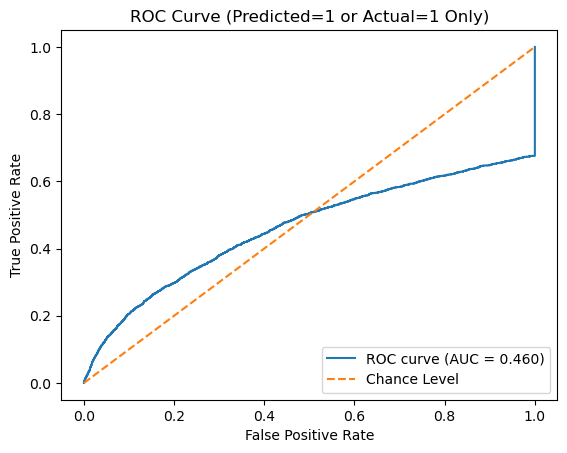

              precision    recall  f1-score   support

         0.0       0.99      0.69      0.82    150769
         1.0       0.04      0.68      0.07      2635

    accuracy                           0.69    153404
   macro avg       0.51      0.68      0.44    153404
weighted avg       0.98      0.69      0.80    153404

[[104398  46371]
 [   854   1781]]


In [25]:
# Get predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Apply the threshold to get the new predictions
y_pred_custom = (y_proba >= optimal_threshold).astype(int)


plot_roc_auc(model, X_test, y_test, optimal_threshold)

print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))

# Feature Importance

In [26]:
feature_importances = model.feature_importances_
features = X_test.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

              Feature  Importance
102            ICULOS    0.044201
73               FiO2    0.031560
85            Lactate    0.028631
20         Temp_5_max    0.026575
65               Temp    0.022688
..                ...         ...
44        MAP_5_slope    0.002743
93                PTT    0.002692
90          TroponinI    0.002579
83   Bilirubin_direct    0.000000
100             Unit2    0.000000

[103 rows x 2 columns]


# Shap Importance

# Utility Score

# Most Important Features